# PyStanによるレプリカ交換モンテカルロ実装
- PyStanを用いてレプリカ交換モンテカルロ法の実装を試行した。
  - @hankagosa さんの実装例<http://statmodeling.hatenablog.com/entry/stan-parallel-tempering>をベースとした。
  - 変更点はPython化と、ベクトル値の引数に対応したことくらい。
- GMM型の分布を設定し、そこから妥当なサンプルが得られるか確認した。

In [1]:
import pickle

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns

from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
from pystan import StanModel 
from scipy.stats import multivariate_normal


In [2]:
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
sns.set_palette('hls')

## 1. 準備
### 1.1. サンプリングする分布の設定

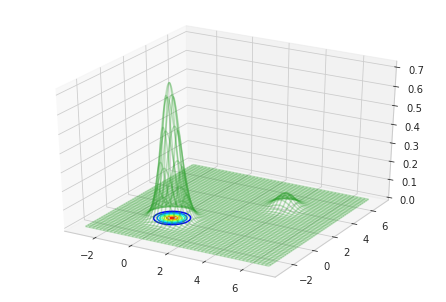

In [3]:
A1 = 0.9 ## ratio of GMM
A2 = 0.1 

grid = np.meshgrid(np.arange(-3, 7, 0.005), np.arange(-3, 7, 0.005))
z = A1*multivariate_normal.pdf(mean=[0, 0], cov=[[0.2, 0], [0, 0.2]], x=np.c_[grid[0].reshape(-1), grid[1].reshape(-1)])
z += A2*multivariate_normal.pdf(mean=[4, 4], cov=[[0.2, 0], [0, 0.2]], x=np.c_[grid[0].reshape(-1), grid[1].reshape(-1)])

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.contour(grid[0], grid[1], z.reshape(grid[0].shape), zdir="z", offset=0.001, cmap=cm.jet)
plt.show()

- この分布から、MCMCによるサンプリングを試行する。
  - 2つの山の間を超えられるか。

### 1.2. Stanモデル定義
- データは入力せず、事前分布からそのままサンプリングを行う。
- 逆温度をdataブロックで与え、逆温度可変でのサンプリングを可能にする。

In [4]:
stancode = """
data {
  real beta;
}

parameters {
  vector[2] p;
}

model {
  vector[2] mu1;
  vector[2] mu2;
  matrix[2, 2] cov1;
  matrix[2, 2] cov2;

  for (d in 1:2) {
    mu1[d] = 0.0;
    mu2[d] = 4.0;
  }
  cov1[1][1] = 0.2; cov1[1][2] = 0.0; cov1[2][1] = 0.0; cov1[2][2] = 0.2;
  cov2[1][1] = 0.2; cov2[1][2] = 0.0; cov2[2][1] = 0.0; cov2[2][2] = 0.2;

  target += beta * log_sum_exp(
    log(0.9) + multi_normal_lpdf(p | mu1, cov1),
    log(0.1) + multi_normal_lpdf(p | mu2, cov2)
  );
}

"""

In [5]:
filename = "./model/gmm-posterior-PT.pickle"
try:
    with open(filename, mode="rb") as f:
        stanmodel = pickle.load(f)
except FileNotFoundError:
    stanmodel = StanModel(model_code=stancode)
    with open(filename, mode="wb") as g:
        pickle.dump(stanmodel, g)

## 2. レプリカ交換モンテカルロ実装

### 2.1. 関数定義
- 交換するレプリカの対を指定する関数

In [6]:
def idx_ex(n_rep, ee):
    idx = np.arange(0, np.floor(n_rep/2), dtype=np.int64) * 2
    if (ee % 2 == 1):
        return idx[:-1] + 1
    else:
        return idx

In [7]:
def cast_staninit(init):
    try:
        return np.asscalar(init)
    except ValueError:
        return init

- 交換モンテカルロ法を実行する関数

In [8]:
def replica_exMCMC(inv_T, n_ex, stanmodel, data, par_list, init, n_iter, warmup):
    par_length = get_par_length(par_list)

    n_rep = len(inv_T)
    len_mcmc = n_iter - warmup
    n_param = np.sum(par_length) + 1 # n_parameters includes lp__.
    ms_T1 = np.zeros((len_mcmc*n_ex, n_param)) # <- MCMC samples at inv_T=1.

    idx_tbl = np.zeros((n_ex, n_rep), dtype=np.int64) # index table of (exchange time, replica)
    E_tbl = np.zeros((n_ex, n_rep)) # E table
    init_list = [init] * n_rep

    for ee in range(n_ex):
        fit_list = []
        for r in range(n_rep):
            data["beta"] = inv_T[r]
            fit_list.append(stanmodel.sampling(data=data, init=init_list[r], iter=n_iter, warmup=warmup, chains=1, seed=r, check_hmc_diagnostics=False))
        ms_T1[ee * len_mcmc : (ee+1) * len_mcmc, :] = fit_list[0].extract(permuted=False, inc_warmup=False)[:,0,:]

        ## exchange replicas
        E = [-fit_list[r].extract(permuted=False, pars="lp__")["lp__"][-1] for r in range(n_rep)]
        idx = np.arange(n_rep, dtype=np.int64)

        for rr in idx_ex(n_rep, ee):
            w = np.exp(-(inv_T[rr+1] - inv_T[rr]) * (E[rr] - E[rr+1]))
            if (np.random.uniform(0,1,1) < w):
                idx[rr] = rr+1
                idx[rr+1] = rr
        E_tbl[ee, :] = E
        idx_tbl[ee, :] = idx

        for rr in range(n_rep):
            ms = fit_list[idx_tbl[ee, rr]].extract(permuted=False)[-1, 0, :np.sum(par_length)]
            init_dict = [dict(zip(par_list, np.split(ms, np.cumsum(par_length))))]
            init_list[rr] = [{k:v for k,v in zip(init_dict[0].keys(), [cast_staninit(init[1]) for init in init_dict[0].items()])}]

    return ms_T1, idx_tbl, E_tbl


In [9]:
def get_par_length(par_list):
    par_length = []
    for item in par_list.values():
        try:
            par_length += [len(item)]
        except TypeError:
            par_length += [1]
    return np.array(par_length)

### 2.2. サンプリング

In [10]:
%%time
data = {}
init = [{"p":np.array([0.0, 0.0])}]

N_rep = 30 ## number of replicas
N_ex = 200 ## number of exchanges
Inv_T = 0.5 ** np.linspace(0, -np.log(0.2)/np.log(2), num=N_rep)

result = replica_exMCMC(inv_T=Inv_T, n_ex=N_ex, stanmodel=stanmodel, data=data, par_list=dict(p=np.array([0, 0])), init=init, n_iter=70, warmup=50)


CPU times: user 35.9 s, sys: 1.43 s, total: 37.4 s
Wall time: 37.5 s


In [11]:
Inv_T

array([1.        , 0.94601405, 0.89494258, 0.84662825, 0.80092222,
       0.75768368, 0.7167794 , 0.67808338, 0.64147641, 0.60684569,
       0.57408455, 0.54309205, 0.51377271, 0.4860362 , 0.45979708,
       0.43497449, 0.41149198, 0.3892772 , 0.3682617 , 0.34838074,
       0.32957307, 0.31178076, 0.29494898, 0.27902588, 0.2639624 ,
       0.24971214, 0.23623119, 0.22347802, 0.21141335, 0.2       ])

## 3. 結果

取得されたサンプルを、正解の分布と重ねて見る。

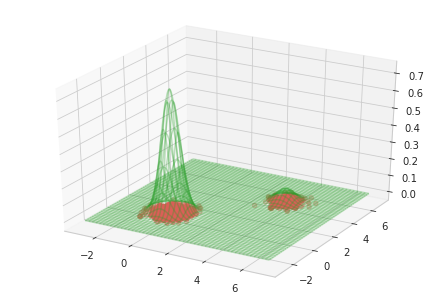

In [12]:
fig = plt.figure()
fig.tight_layout()
ax = Axes3D(fig)

ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.scatter(result[0][100:,0], result[0][100:,1], alpha=0.3)
plt.show()

- 谷を超えて、双方の峰からサンプリングできていた。

Z軸に事後確率を取り、サンプルの挙動をプロットする。

In [13]:
df = pd.DataFrame({"p0":result[0][100:,0], "p1":result[0][100:,1], "E":result[0][100:,2]})

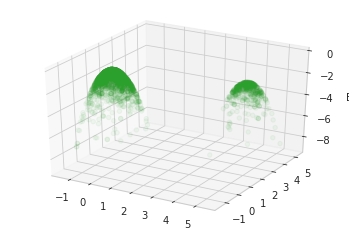

In [14]:
td = plt.figure().gca(projection="3d")
td.scatter(df["p0"], df["p1"], df["E"], color="tab:green", alpha=0.05)
td.set_zlabel('E')
plt.show()

traceplot

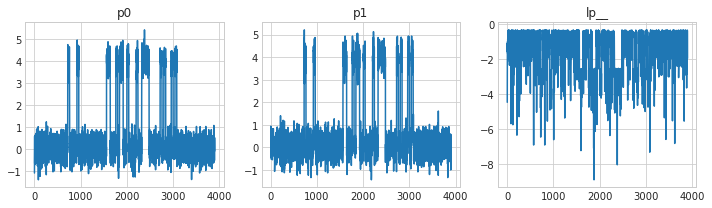

In [15]:
params = ["p0", "p1", "lp__"]
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for ii in range(3):
    ax[ii].set_title(params[ii])
    ax[ii].plot(result[0][100:,ii], color="tab:blue")
fig.tight_layout()
plt.show()

- 峰の間を複数回行き来したことが確認できる。